In [1]:
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util

from astropy.io import ascii
import numpy as np
import matplotlib.pyplot as plt

### Reading the spectra file which is in ascii format with first column containing wavelength data and second column containing relative flux or spectra.

In [3]:
data = ascii.read('../comb05.spec')
lamda_galaxy = data['col1']
spectra_galaxy = data['col2']
lamda_galaxy_range =  [np.min(lamda_galaxy), np.max(lamda_galaxy)]
print(lamda_galaxy_range)

[5561.54, 8116.54]


### Normalizing the input spectra to avoid numerical problems as suggested by the package. It says--   'Make sure the spectra are rescaled to be not too many order of magnitude different from unity, to avoid  over or underflow problems in the calculation.' 
### Both the input spectra and templates have to be logarithmically rebinned inorder to use as input for the main function of the package. As the 'log_rebin' function of the package keep the flux fixed, it does not matter whether the normalization has been done before or after rebinning.

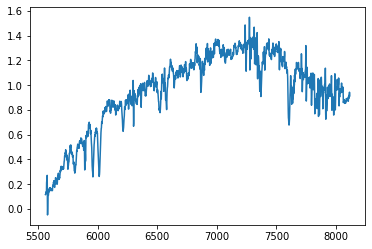

In [4]:
spectra_galaxy = spectra_galaxy / np.median(spectra_galaxy)
plt.plot(lamda_galaxy, spectra_galaxy)

### We need to provide a velocity scale about which the velocity dispersion will be calculated. It has to be the same for both the galaxy and the template spectra. This velocity scale can be calculated from wavelength of the spectra or from priliminary estimated redshift of galaxy. According to the section 2.3 of the paper [Cappellari (2017)](https://ui.adsabs.harvard.edu/abs/2017MNRAS.466..798C) in the limit of small V,   
$$V \equiv c \Delta ln \lambda = cln(1+z)$$


In [5]:
c = 299792.458                                 # speed of light in km/s
frac_lamda = lamda_galaxy[1]/ lamda_galaxy[0]  # Constant lambda fraction per pixel
velocity_scale =  np.log(frac_lamda)*c         # velocity scale in km/s per pixel
print('Velocity_scale=', velocity_scale)

Velocity_scale= 67.373149497962


### Here we logarithmically rebinning the input spectra inorder to use as input for the main function of the package. 

In [6]:
spectra_galaxy_new, log_lamda_galaxy, v = util.log_rebin(lamda_galaxy_range, spectra_galaxy, 
                                                         velscale=velocity_scale)

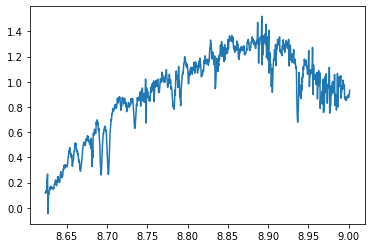

In [7]:
plt.plot(log_lamda_galaxy, spectra_galaxy_new)

### Here we are using only one template spectra to compare or fit with the input spectra. The wavelength range of input spectra and template are quiet different. Not sure whether to use only the data from both spectras for the common wavelength range in order to fit ?

In [9]:
template_data = ascii.read('../MILES_library_v9.1_ASCII/s0010') # a random tamplate from library
lamda_template = template_data['col1']                       # wavelength in angstrom
spectra_template = template_data['col2']                     # spectra
lamda_template_range = [np.min(template_data['col1']), np.max(template_data['col1'])]
print(lamda_template_range)

[3500.0, 7429.4]


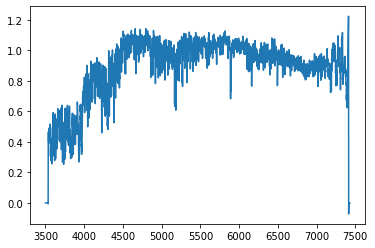

In [10]:
plt.plot(lamda_template, spectra_template)

### Here we logarithmically rebinning the tamplate spectra inorder to use as input for the main function of the package.

In [11]:
spectra_template_new, log_lamda_template, vscale = util.log_rebin(lamda_template_range, spectra_template, 
                                                                  velscale=velocity_scale)

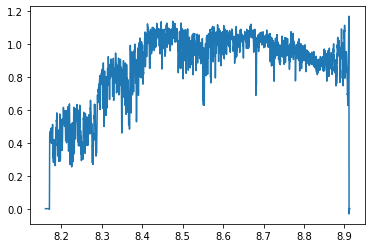

In [12]:
plt.plot(log_lamda_template, spectra_template_new)

### Noise is a required input parameter for the main function. As no reliable noise is available we have to assume constant noise per pixel. The noise array should have the same size as input spectra. The noise chosen here is following an example code in the package

In [13]:
noise = np.full_like(spectra_galaxy_new, 0.0166)

###  We need to provide an initial estimate for the LOSVD (line of sight velocity distribution) parameters. If these parameters are not held fixed then need to provide an estimate only for velocity and velocity dispersion which are first and second elements in the arary 'start'. According to the package, unless a good initial guess is available, it is recommended to set the starting sigma >= 3*velscale in km/s (i.e. 3 pixels).  Calculated velocity scale from input spectra is 67.37 km/s. So the initial guess for velocity dispersion is more than three times of velocity scale.

In [14]:
z = 0.516               # redshift from input spectra
vel = c*np.log(1 + z)   # eq.(8) of Cappellari (2017)
start = [vel, 200.]     

### The five required inputs for the main function which is 'ppxf' are logarithmically rebinned input spectra, and templates, noise, velocity scale and start. There are lots of other optional parameters enabling various features. The 'moments' parameter can be used to define how many statistical moments we are interested in fitting. 

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    125565       116    -0.000    -0.004
chi2/DOF: 31.53
method = capfit; Jac calls: 6; Func calls: 34; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  0 / 1
Templates weights:
   -0.0481


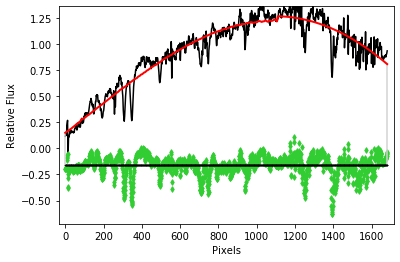

In [15]:
pp = ppxf(spectra_template_new, spectra_galaxy_new, noise, velocity_scale, start, moments=4,
         plot=True)

### Using 'lam' parameter we can have the best fit plot in wavelengths rather than pixel value.

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    125565       116    -0.000    -0.004
chi2/DOF: 31.53
method = capfit; Jac calls: 6; Func calls: 34; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  0 / 1
Templates weights:
   -0.0481


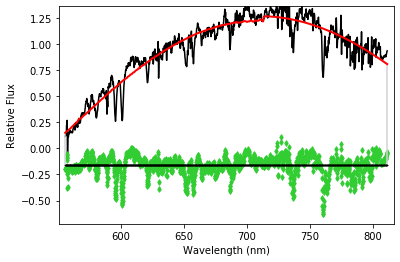

In [16]:
pp = ppxf(spectra_template_new, spectra_galaxy_new, noise, velocity_scale, start, moments=4,
         plot=True, lam=np.exp(log_lamda_galaxy))